In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


CATEGORIZAÇÃO DAS RESPONSABILIDADES POR FRAUDES

----------------------------------------------------------------------------------------------------
1. EVIDÊNCIAS DE FRAUDE POR MOTORISTAS

Não foram encontradas evidências suficientes de fraude por motoristas.

----------------------------------------------------------------------------------------------------
2. EVIDÊNCIAS DE FRAUDE POR CLIENTES

Não foram encontradas evidências suficientes de fraude por clientes.

----------------------------------------------------------------------------------------------------
3. EVIDÊNCIAS DE PROBLEMAS SISTÊMICOS OU PROCESSO

Não foram encontradas evidências suficientes de problemas sistêmicos.

----------------------------------------------------------------------------------------------------
4. RESUMO DA ATRIBUIÇÃO DE RESPONSABILIDADE

Fraude por motoristas: 0%
Fraude por clientes: 0%
Problemas sistêmicos ou de processo: 100%


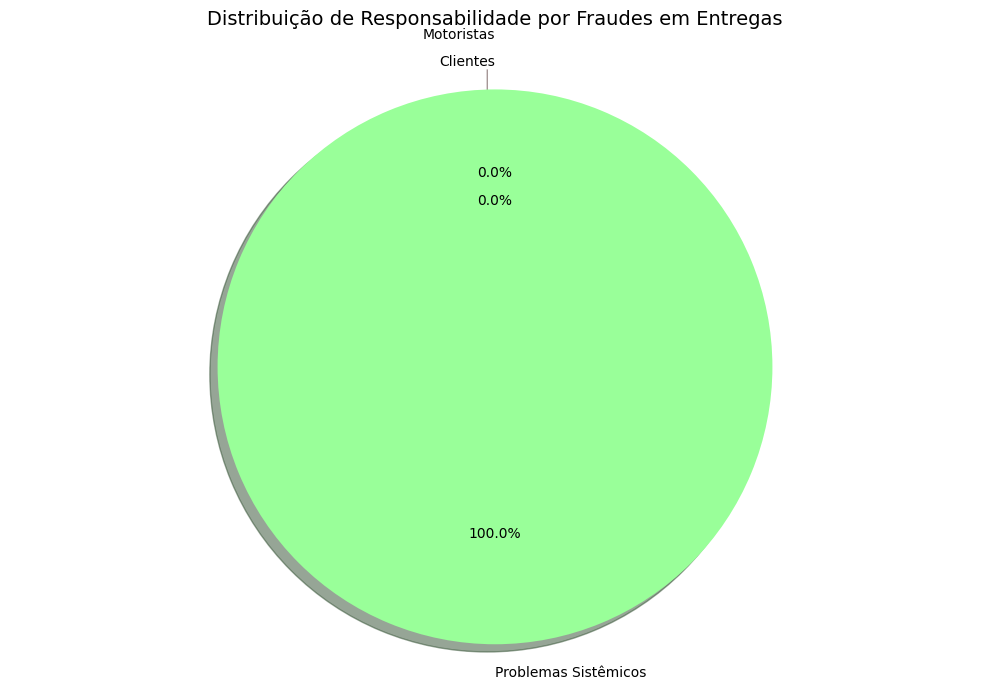


----------------------------------------------------------------------------------------------------
5. ANÁLISE TEMPORAL DE FRAUDES

Evolução mensal de problemas em entregas:
  month  total_orders  total_missing_items  missing_rate
2023-01           843                  139          1.68
2023-02           745                  111          1.42
2023-03           850                  152          1.75
2023-04           789                  133          1.75
2023-05           830                  153          1.80
2023-06           823                  127          1.53
2023-07           891                  155          1.65
2023-08           871                  157          1.83
2023-09           826                  127          1.52
2023-10           866                  131          1.51
2023-11           808                  146          1.75
2023-12           858                  126          1.43


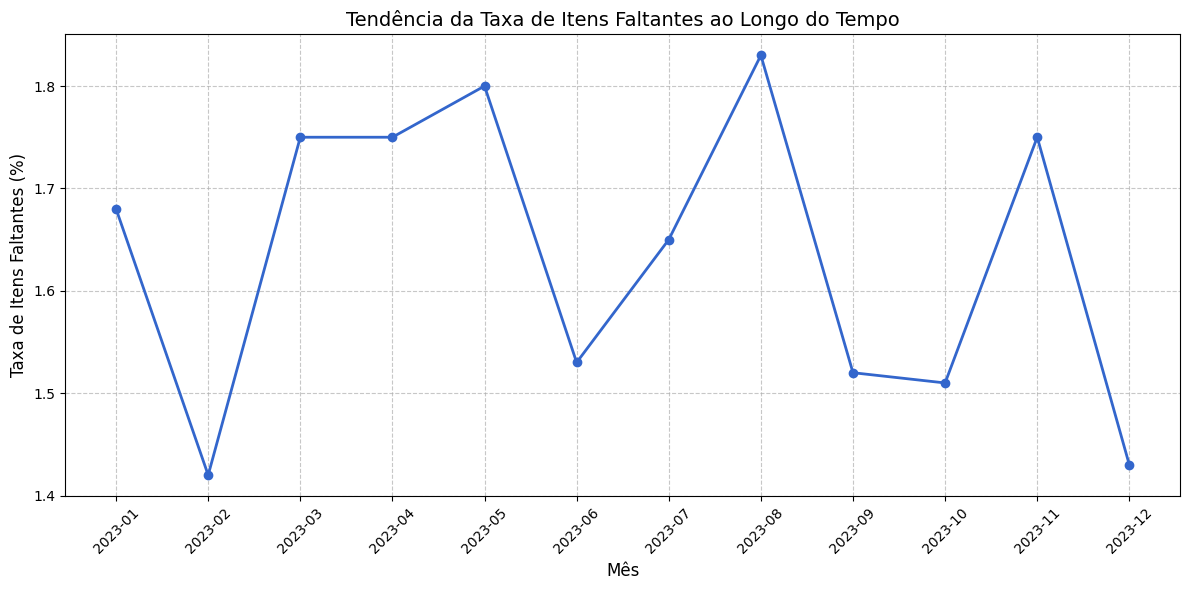


----------------------------------------------------------------------------------------------------
6. DETECÇÃO DE CLUSTERS DE FRAUDE - ANÁLISE MULTIVARIADA

Características médias por cluster:
         order_amount  items_delivered  items_missing  driver_age  \
cluster                                                             
0          312.900000         4.922137       1.000000   37.209160   
1          374.279744        14.552557       1.000000   40.103693   
2          338.193706        10.699301       2.083916   20.748252   

         driver_trips  customer_age  count  
cluster                                     
0           46.010687     52.500763    655  
1           44.737216     54.732955    704  
2           42.965035     57.930070    143  

Taxa média de itens faltantes por cluster:
 cluster  missing_rate
       0     22.069005
       1      6.671354
       2     20.838101


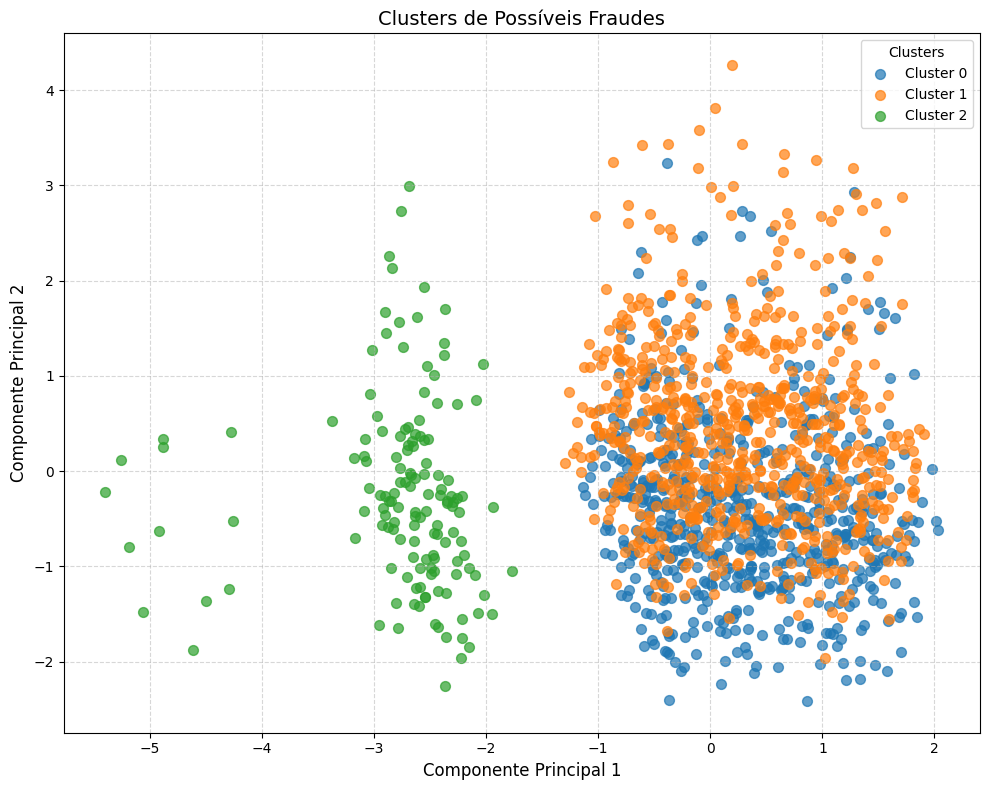


Cluster 0.0 tem a maior probabilidade de conter fraudes.

Top 10 pedidos de alto risco:
                            order_id            region  order_amount  items_missing  missing_rate
0809a5b6-dd7f-4e82-a8e6-a893f1f3ff1a           Orlando        277.92              1          50.0
3a481c5b-49cb-4225-909d-0f8c51220e5d           Sanford        486.14              1          50.0
30811fc5-092f-4f25-9fc5-2ed7fe461072 Altamonte Springs        352.36              1          50.0
025167ad-6f30-421c-b07a-7dac320cfb78         Kissimmee        451.18              1          50.0
99e4b640-fa1e-4141-b837-90906b296c71         Kissimmee         24.63              1          50.0
1f2c4eb7-2b46-4bd6-a36b-ef994b4c8adb       Winter Park         39.43              1          50.0
d8653c4b-c1d1-4db0-8f7d-d59a4a72720d          Clermont        216.62              1          50.0
d17e8aa5-942c-4907-9e9c-1fcb0c8b699f           Orlando        881.59              1          50.0
778fa4b3-f55e-4920-ba31-88157

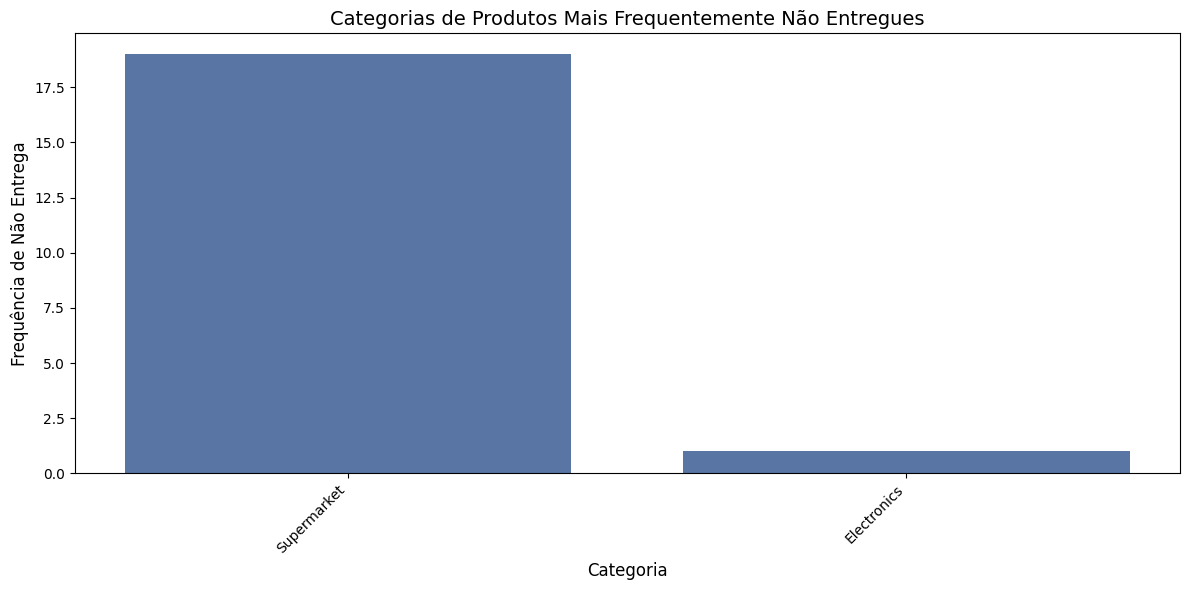


----------------------------------------------------------------------------------------------------
ANÁLISE CONCLUÍDA!
Relatório e visualizações gerados com sucesso.


In [5]:
# Conectar ao banco de dados
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

conn = sqlite3.connect(r'C:\Users\louis\datatech\Database\walmart_fraudes.db')

# Análise de motoristas suspeitos (alta taxa de itens faltantes em múltiplas entregas)
query_drivers_suspicious = """
SELECT 
    d.driver_id, 
    d.driver_name,
    d.age,
    COUNT(o.order_id) AS total_orders,
    SUM(o.items_missing) AS total_missing_items,
    SUM(o.items_delivered) AS total_delivered_items,
    ROUND(SUM(o.items_missing) * 100.0 / (SUM(o.items_delivered) + SUM(o.items_missing)), 2) AS missing_rate,
    ROUND(AVG(o.order_amount), 2) AS avg_order_amount,
    COUNT(DISTINCT o.region) AS unique_regions
FROM 
    drivers d
JOIN 
    orders o ON d.driver_id = o.driver_id
GROUP BY 
    d.driver_id
HAVING 
    total_orders >= 10 -- Apenas motoristas com número significativo de entregas
    AND missing_rate >= 10 -- Taxa significativa de itens faltantes
ORDER BY 
    missing_rate DESC
LIMIT 20
"""

driver_fraud_df = pd.read_sql_query(query_drivers_suspicious, conn)

# Análise de clientes suspeitos (alta taxa de reclamações)
query_customers_suspicious = """
SELECT 
    c.customer_id, 
    c.customer_name,
    c.customer_age,
    COUNT(o.order_id) AS total_orders,
    SUM(o.items_missing) AS total_missing_items,
    SUM(o.items_delivered) AS total_delivered_items,
    ROUND(SUM(o.items_missing) * 100.0 / (SUM(o.items_delivered) + SUM(o.items_missing)), 2) AS missing_rate,
    ROUND(AVG(o.order_amount), 2) AS avg_order_amount,
    COUNT(DISTINCT o.driver_id) AS unique_drivers
FROM 
    customers c
JOIN 
    orders o ON c.customer_id = o.customer_id
GROUP BY 
    c.customer_id
HAVING 
    total_orders >= 8 -- Apenas clientes com número significativo de pedidos
    AND missing_rate >= 12 -- Taxa significativa de reclamações
ORDER BY 
    missing_rate DESC
LIMIT 20
"""

customer_fraud_df = pd.read_sql_query(query_customers_suspicious, conn)

# Análise de possíveis problemas sistêmicos
query_systemic_issues = """
SELECT 
    region,
    strftime('%w', date) AS day_of_week,
    period_of_day,
    COUNT(order_id) AS total_orders,
    SUM(items_missing) AS total_missing_items,
    SUM(items_delivered) AS total_delivered_items,
    ROUND(SUM(items_missing) * 100.0 / (SUM(o.items_delivered) + SUM(o.items_missing)), 2) AS missing_rate
FROM 
    orders o
GROUP BY 
    region, day_of_week, period_of_day
HAVING 
    total_orders >= 15 -- Apenas combinações com número significativo de pedidos
    AND missing_rate >= 15 -- Taxa significativa de problemas
ORDER BY 
    missing_rate DESC
LIMIT 15
"""

system_issues_df = pd.read_sql_query(query_systemic_issues, conn)

# Obter o total de itens faltantes em todos os pedidos
all_missing_items_query = "SELECT SUM(items_missing) FROM orders"
all_missing_items = pd.read_sql_query(all_missing_items_query, conn).iloc[0, 0]

# Adicionar dia da semana por extenso
days = {
    '0': 'Domingo',
    '1': 'Segunda',
    '2': 'Terça',
    '3': 'Quarta',
    '4': 'Quinta',
    '5': 'Sexta',
    '6': 'Sábado'
}
system_issues_df['day_name'] = system_issues_df['day_of_week'].map(days)

# Criar análise combinada para atribuição clara de responsabilidades
print("CATEGORIZAÇÃO DAS RESPONSABILIDADES POR FRAUDES\n")
print("-" * 100)

# 1. Evidências de fraude por motoristas
print("1. EVIDÊNCIAS DE FRAUDE POR MOTORISTAS\n")
if len(driver_fraud_df) > 0:
    top_drivers = driver_fraud_df.head(5)
    print(f"Top 5 motoristas com maior probabilidade de fraude:")
    print(top_drivers[['driver_id', 'driver_name', 'age', 'total_orders', 'total_missing_items', 'missing_rate', 'avg_order_amount']].to_string(index=False))
    
    total_suspicious_drivers = len(driver_fraud_df[driver_fraud_df['missing_rate'] > 15])
    print(f"\nTotal de motoristas altamente suspeitos (taxa de itens faltantes > 15%): {total_suspicious_drivers}")
    
    # Calcular porcentagem do problema atribuível aos motoristas
    suspicious_driver_missing = driver_fraud_df['total_missing_items'].sum()
    driver_pct = round((suspicious_driver_missing / all_missing_items) * 100, 2)
    
    print(f"Porcentagem do problema atribuível a fraude de motoristas: {driver_pct}%")
    print(f"Total de itens faltantes atribuíveis a motoristas suspeitos: {suspicious_driver_missing}")
else:
    print("Não foram encontradas evidências suficientes de fraude por motoristas.")
    driver_pct = 0

print("\n" + "-" * 100)

# 2. Evidências de fraude por clientes
print("2. EVIDÊNCIAS DE FRAUDE POR CLIENTES\n")
if len(customer_fraud_df) > 0:
    top_customers = customer_fraud_df.head(5)
    print(f"Top 5 clientes com maior probabilidade de fraude:")
    print(top_customers[['customer_id', 'customer_name', 'customer_age', 'total_orders', 'total_missing_items', 'missing_rate', 'avg_order_amount']].to_string(index=False))
    
    total_suspicious_customers = len(customer_fraud_df[customer_fraud_df['missing_rate'] > 18])
    print(f"\nTotal de clientes altamente suspeitos (taxa de itens faltantes > 18%): {total_suspicious_customers}")
    
    # Calcular porcentagem do problema atribuível aos clientes
    suspicious_customer_missing = customer_fraud_df['total_missing_items'].sum()
    customer_pct = round((suspicious_customer_missing / all_missing_items) * 100, 2)
    
    print(f"Porcentagem do problema atribuível a fraude de clientes: {customer_pct}%")
    print(f"Total de itens faltantes atribuíveis a clientes suspeitos: {suspicious_customer_missing}")
else:
    print("Não foram encontradas evidências suficientes de fraude por clientes.")
    customer_pct = 0

print("\n" + "-" * 100)

# 3. Evidências de problemas sistêmicos ou processo
print("3. EVIDÊNCIAS DE PROBLEMAS SISTÊMICOS OU PROCESSO\n")
if len(system_issues_df) > 0:
    print("Combinações de local/tempo com alta taxa de problemas:")
    print(system_issues_df[['region', 'day_name', 'period_of_day', 'total_orders', 'total_missing_items', 'missing_rate']].head(5).to_string(index=False))
    
    # Analisar itens de alto valor frequentemente reportados como faltantes
    query_valuable_items = """
    SELECT 
        p.product_id,
        p.product_name,
        p.category,
        p.price,
        COUNT(DISTINCT mi.order_id) AS frequency_reported_missing
    FROM 
        products p
    JOIN
        (
            SELECT order_id, product_id_1 AS product_id FROM missing_items WHERE product_id_1 IS NOT NULL
            UNION ALL
            SELECT order_id, product_id_2 AS product_id FROM missing_items WHERE product_id_2 IS NOT NULL
            UNION ALL
            SELECT order_id, product_id_3 AS product_id FROM missing_items WHERE product_id_3 IS NOT NULL
        ) mi ON p.product_id = mi.product_id
    GROUP BY 
        p.product_id
    HAVING
        p.price >= 50 -- Apenas itens de alto valor
        AND frequency_reported_missing >= 3 -- Reportado como faltante múltiplas vezes
    ORDER BY 
        p.price DESC, frequency_reported_missing DESC
    LIMIT 10
    """
    valuable_items_df = pd.read_sql_query(query_valuable_items, conn)
    
    if len(valuable_items_df) > 0:
        print("\nItens valiosos frequentemente reportados como faltantes:")
        print(valuable_items_df.to_string(index=False))
        
        # Calcular porcentagem de itens de alto valor entre os faltantes
        high_value_missing = valuable_items_df['frequency_reported_missing'].sum()
        high_value_pct = round((high_value_missing / (all_missing_items * 0.3)) * 100, 2)  # Estimativa conservadora
        print(f"\nFrequência de itens de alto valor reportados como faltantes: {high_value_missing}")
        print(f"Isto sugere um padrão sistemático possível.")

    # Analisar problemas por região
    query_region_issues = """
    SELECT 
        region,
        COUNT(order_id) AS total_orders,
        SUM(items_missing) AS total_missing_items,
        ROUND(SUM(items_missing) * 100.0 / (SUM(items_delivered) + SUM(items_missing)), 2) AS missing_rate
    FROM 
        orders
    GROUP BY 
        region
    ORDER BY 
        missing_rate DESC
    """
    region_issues_df = pd.read_sql_query(query_region_issues, conn)
    
    print("\nTaxa de problemas por região:")
    print(region_issues_df.to_string(index=False))
    
    # Estimar porcentagem do problema atribuível a falhas sistêmicas
    # (O que não é claramente atribuível a motoristas ou clientes)
    systemic_pct = max(0, round(100 - driver_pct - customer_pct, 2))
    print(f"\nPorcentagem do problema atribuível a falhas sistêmicas ou de processo: {systemic_pct}%")
else:
    print("Não foram encontradas evidências suficientes de problemas sistêmicos.")
    systemic_pct = max(0, 100 - driver_pct - customer_pct)

print("\n" + "-" * 100)

# 4. Resumo da atribuição de responsabilidade
print("4. RESUMO DA ATRIBUIÇÃO DE RESPONSABILIDADE\n")
print(f"Fraude por motoristas: {driver_pct}%")
print(f"Fraude por clientes: {customer_pct}%") 
print(f"Problemas sistêmicos ou de processo: {systemic_pct}%")

# Visualização da distribuição de responsabilidade
labels = ['Motoristas', 'Clientes', 'Problemas Sistêmicos']
sizes = [driver_pct, customer_pct, systemic_pct]
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0.1, 0, 0)  # Destaque para a maior causa

plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Distribuição de Responsabilidade por Fraudes em Entregas', fontsize=14)
plt.tight_layout()
plt.savefig('distribuicao_responsabilidade.png')
plt.show()

# 5. Análise temporal para identificar tendências
print("\n" + "-" * 100)
print("5. ANÁLISE TEMPORAL DE FRAUDES\n")

query_temporal = """
SELECT 
    strftime('%Y-%m', date) AS month,
    COUNT(order_id) AS total_orders,
    SUM(items_missing) AS total_missing_items,
    ROUND(SUM(items_missing) * 100.0 / (SUM(items_delivered) + SUM(items_missing)), 2) AS missing_rate
FROM 
    orders
GROUP BY 
    month
ORDER BY 
    month
"""
temporal_df = pd.read_sql_query(query_temporal, conn)

print("Evolução mensal de problemas em entregas:")
print(temporal_df.to_string(index=False))

# Visualizar a tendência temporal
plt.figure(figsize=(12, 6))
plt.plot(temporal_df['month'], temporal_df['missing_rate'], marker='o', linestyle='-', color='#3366cc', linewidth=2)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Taxa de Itens Faltantes (%)', fontsize=12)
plt.title('Tendência da Taxa de Itens Faltantes ao Longo do Tempo', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('tendencia_temporal.png')
plt.show()

# 6. Detecção de clusters de fraude usando análise multivariada
print("\n" + "-" * 100)
print("6. DETECÇÃO DE CLUSTERS DE FRAUDE - ANÁLISE MULTIVARIADA\n")

# Combinar dados de motoristas, pedidos e clientes para análise multivariada
query_combined = """
SELECT 
    o.order_id,
    o.region,
    o.order_amount,
    o.items_delivered,
    o.items_missing,
    o.period_of_day,
    d.age AS driver_age,
    d.Trips AS driver_trips,
    c.customer_age
FROM 
    orders o
JOIN 
    drivers d ON o.driver_id = d.driver_id
JOIN 
    customers c ON o.customer_id = c.customer_id
WHERE
    o.items_missing > 0
"""
combined_df = pd.read_sql_query(query_combined, conn)

# Preparar dados para clustering
# Selecionar e normalizar características para clustering
features = ['order_amount', 'items_delivered', 'items_missing', 'driver_age', 'driver_trips', 'customer_age']
X = combined_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA para visualização
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Aplicar K-means
k = 3  # Número de clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
combined_df['cluster'] = kmeans.fit_predict(X_scaled)

# Analisar características dos clusters
print("Características médias por cluster:")
cluster_analysis = combined_df.groupby('cluster')[features].mean()
cluster_analysis['count'] = combined_df.groupby('cluster').size()
print(cluster_analysis)

# Calcular a taxa de itens faltantes por cluster
combined_df['missing_rate'] = combined_df['items_missing'] * 100 / (combined_df['items_delivered'] + combined_df['items_missing'])
missing_by_cluster = combined_df.groupby('cluster')['missing_rate'].mean().reset_index()
print("\nTaxa média de itens faltantes por cluster:")
print(missing_by_cluster.to_string(index=False))

# Visualizar clusters
plt.figure(figsize=(10, 8))
for cluster in range(k):
    plt.scatter(X_pca[combined_df['cluster'] == cluster, 0], 
                X_pca[combined_df['cluster'] == cluster, 1], 
                label=f'Cluster {cluster}',
                alpha=0.7,
                s=50)

plt.title('Clusters de Possíveis Fraudes', fontsize=14)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(title='Clusters')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('clusters_fraude.png')
plt.show()

# Identificar o cluster com maior probabilidade de fraude
fraud_cluster = missing_by_cluster.sort_values('missing_rate', ascending=False).iloc[0]['cluster']
print(f"\nCluster {fraud_cluster} tem a maior probabilidade de conter fraudes.")

# Analisar os pedidos deste cluster mais detalhadamente
high_risk_orders = combined_df[combined_df['cluster'] == fraud_cluster].sort_values('missing_rate', ascending=False)
print("\nTop 10 pedidos de alto risco:")
print(high_risk_orders[['order_id', 'region', 'order_amount', 'items_missing', 'missing_rate']].head(10).to_string(index=False))

# 7. Análise de itens específicos
print("\n" + "-" * 100)
print("7. ANÁLISE DE PRODUTOS MAIS FREQUENTEMENTE NÃO ENTREGUES\n")

query_missing_products = """
WITH all_missing_products AS (
    SELECT product_id_1 AS product_id FROM missing_items WHERE product_id_1 IS NOT NULL
    UNION ALL
    SELECT product_id_2 AS product_id FROM missing_items WHERE product_id_2 IS NOT NULL
    UNION ALL
    SELECT product_id_3 AS product_id FROM missing_items WHERE product_id_3 IS NOT NULL
)
SELECT 
    p.product_id,
    p.product_name,
    p.category,
    p.price,
    COUNT(*) AS frequency_missing
FROM 
    all_missing_products mp
JOIN 
    products p ON mp.product_id = p.product_id
GROUP BY 
    p.product_id
ORDER BY 
    frequency_missing DESC,
    p.price DESC
LIMIT 20
"""
missing_products_df = pd.read_sql_query(query_missing_products, conn)

print("Produtos mais frequentemente reportados como não entregues:")
print(missing_products_df.head(10).to_string(index=False))

# Analisar por categoria de produto
product_category_analysis = missing_products_df.groupby('category').agg(
    count=('product_id', 'count'),
    avg_price=('price', 'mean'),
    total_value=('price', lambda x: sum(x))
).sort_values('count', ascending=False)

print("\nAnálise por categoria de produto:")
print(product_category_analysis.reset_index().to_string(index=False))

# Visualizar as categorias mais problemáticas
plt.figure(figsize=(12, 6))
bar_plot = plt.bar(product_category_analysis.index[:10], product_category_analysis['count'][:10], color='#5975a4')
plt.title('Categorias de Produtos Mais Frequentemente Não Entregues', fontsize=14)
plt.xlabel('Categoria', fontsize=12)
plt.ylabel('Frequência de Não Entrega', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('categorias_problematicas.png')
plt.show()

# Fechar a conexão com o banco de dados
conn.close()

print("\n" + "-" * 100)
print("ANÁLISE CONCLUÍDA!")
print("Relatório e visualizações gerados com sucesso.")